In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.auto import trange

In [62]:
df = pd.read_csv("../../../../estsoft/data/train.csv")
def fill_null(df:pd.DataFrame, time_before:list, time:list, time_after:list):
    df_fill = pd.DataFrame()
    for i in range(len(time_before)):
        df_null = df[df['datetime']==time[i]]
        df_concat = pd.concat([df[df['datetime']==time_before[i]], df[df['datetime']==time_after[i]]])

        # null값의 앞뒤 시간의 평균값 계산 및 저장
        ab_mean = pd.DataFrame(df_concat.groupby(['prediction_unit_id'])['target'].sum()/2).reset_index()
        df_merge = pd.merge(df_null, ab_mean, how='left', on='prediction_unit_id').drop(columns='target_x').rename(columns={'target_y':'target'})
        df_fill = pd.concat([df_fill, df_merge])

        # null값이 있는 행 drop
        df = df.drop(df_null.index)

    df = pd.concat([df, df_fill]).reset_index(drop=True).sort_values(by='datetime')
    return df
df_prod =df[df['is_consumption']==0]
df_cons = df[df['is_consumption']==1]

time_before = ['2022-10-30 02:00:00', '2022-03-27 02:00:00', '2023-03-26 02:00:00', '2021-10-31 02:00:00']
time = ['2022-10-30 03:00:00', '2022-03-27 03:00:00', '2023-03-26 03:00:00', '2021-10-31 03:00:00']
time_after = ['2022-10-30 04:00:00', '2022-03-27 04:00:00', '2023-03-26 04:00:00', '2021-10-31 04:00:00']

df_prod = fill_null(df_prod, time_before, time, time_after)
df_cons = fill_null(df_cons, time_before, time, time_after)

In [63]:
df_prod['datetime'] = pd.to_datetime(df_prod['datetime'])
print(df_prod.info())
df_prod.set_index('datetime', drop=True, inplace=True) 

df_cons['datetime'] = pd.to_datetime(df_cons['datetime'])
print(df_cons.info())
df_cons.set_index('datetime', drop=True, inplace=True) 

<class 'pandas.core.frame.DataFrame'>
Index: 1009176 entries, 0 to 1008853
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   county              1009176 non-null  int64         
 1   is_business         1009176 non-null  int64         
 2   product_type        1009176 non-null  int64         
 3   target              1009176 non-null  float64       
 4   is_consumption      1009176 non-null  int64         
 5   datetime            1009176 non-null  datetime64[ns]
 6   data_block_id       1009176 non-null  int64         
 7   row_id              1009176 non-null  int64         
 8   prediction_unit_id  1009176 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(7)
memory usage: 77.0 MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 1009176 entries, 0 to 1008853
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype         
---  ------    

In [64]:
# f"df_prod{n}"
df_prod_list = []
for id in df_prod['prediction_unit_id'].unique():
    exec(f"df_prod{id} = df_prod[df_prod['prediction_unit_id']=={id}]")
    exec(f"df_prod_list.append('df_prod{id}')")

# f"df_cons{n}"
df_cons_list = []
for id in df_cons['prediction_unit_id'].unique():
    exec(f"df_cons{id} = df_cons[df_cons['prediction_unit_id']=={id}]")
    exec(f"df_cons_list.append('df_cons{id}')")

# PatchTST

In [65]:
class PatchTSDataset(torch.utils.data.Dataset):
  def __init__(self, ts:np.array, patch_size:int=4, n_token:int=6):
    self.patch_size = patch_size # 4
    self.n_patch = 4
    self.n_token = n_token # 6
    self.window_size = int(patch_size * self.n_patch * n_token / 2) # 4*4*6 = 96
    self.forecast_size = patch_size # 4
    self.data = ts

  def __len__(self):
    return len(self.data) - self.window_size - self.forecast_size + 1 # len 접근시 맨 마지막 데이터 출력해줌

  def __getitem__(self, i): # index 접근시 "
    look_back = self.data[i:(i+self.window_size)] # i:i+96
    look_back = np.concatenate([look_back] + [look_back[-self.patch_size:]] * int(self.n_patch / 2)) # i:i+96 + -4: * 2
    x = np.array([look_back[i*int(self.patch_size*self.n_patch/2):(i+2)*int(self.patch_size*self.n_patch/2)] for i in range(self.n_token)])
    # [i*int(4*4/2):(i+2)*4*4/2] = [i*int(8):(i+2)*int(8)] for i in range(6)

    y = self.data[(i+self.window_size):(i+self.window_size+self.forecast_size)] # i+96:i+96+4 = i+96:i+100
    return x, y

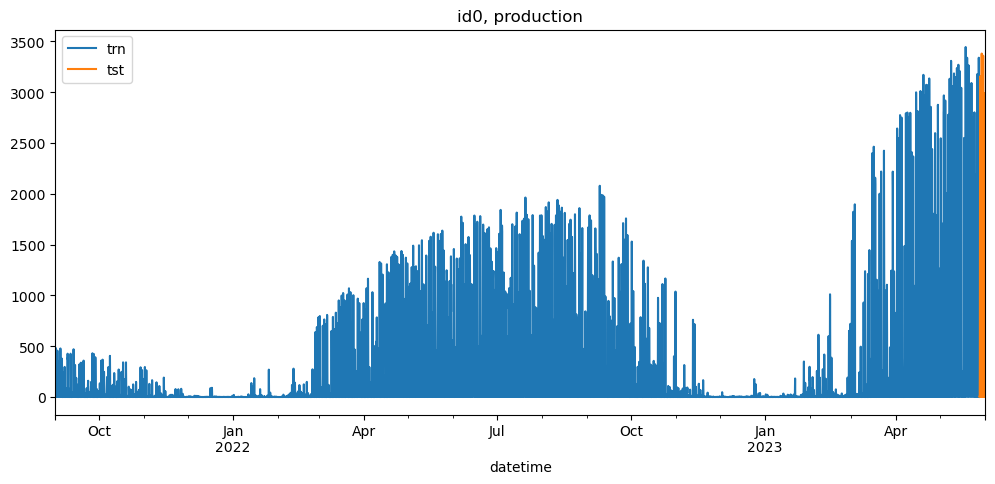

In [66]:
patch_size, n_patch, n_token = 4, 4, 6
window_size = int(patch_size * n_patch * n_token / 2)
tst_size = 96
trn, tst = df_prod0[:-tst_size].target, df_prod0[-tst_size:].target
ax = trn.plot(title="id0, production", label='trn', figsize=(12,5))
tst.plot(label='tst', ax=ax)
plt.legend()
plt.show()

In [67]:
trn

datetime
2021-09-01 00:00:00      0.713
2021-09-01 01:00:00      1.132
2021-09-01 02:00:00      0.490
2021-09-01 03:00:00      0.496
2021-09-01 04:00:00      0.149
                        ...   
2023-05-27 19:00:00    466.393
2023-05-27 20:00:00    149.916
2023-05-27 21:00:00     21.362
2023-05-27 22:00:00      3.359
2023-05-27 23:00:00      2.798
Name: target, Length: 15216, dtype: float64

In [68]:
tst

datetime
2023-05-28 00:00:00      3.401
2023-05-28 01:00:00      3.039
2023-05-28 02:00:00      1.886
2023-05-28 03:00:00      1.347
2023-05-28 04:00:00      3.016
                        ...   
2023-05-31 19:00:00    439.610
2023-05-31 20:00:00    120.856
2023-05-31 21:00:00     22.428
2023-05-31 22:00:00      5.086
2023-05-31 23:00:00      2.921
Name: target, Length: 96, dtype: float64

In [69]:
patch_size, n_patch, n_token = 4, 4, 6
window_size = int(patch_size * n_patch * n_token / 2)

scaler = MinMaxScaler()
trn_scaled = scaler.fit_transform(df_prod0[:-tst_size].to_numpy(dtype=np.float32)).flatten()
tst_scaled = scaler.transform(df_prod0[-tst_size-window_size:].to_numpy(dtype=np.float32)).flatten()

trn_ds = PatchTSDataset(trn_scaled, 4, 6)
tst_ds = PatchTSDataset(tst_scaled, 4, 6)

trn_dl = torch.utils.data.DataLoader(trn_ds, batch_size=32, shuffle=True)
tst_dl = torch.utils.data.DataLoader(tst_ds, batch_size=tst_size, shuffle=False)

In [70]:
m_data = df_prod.copy()
m_data['rolling_mean'] = df_prod.target.rolling(11).mean()
m_data

,county,is_business,product_type,target,is_consumption,data_block_id,row_id,prediction_unit_id,rolling_mean
datetime,,,,,,,,,
2021-09-01 00:00:00,0,0,1,0.713,0,0,0,0,NaN
2021-09-01 00:00:00,8,1,3,0.000,0,0,66,33,NaN
2021-09-01 00:00:00,9,0,1,0.000,0,0,68,34,NaN
2021-09-01 00:00:00,9,0,3,0.089,0,0,70,35,NaN
2021-09-01 00:00:00,9,1,1,0.000,0,0,72,36,NaN
...,...,...,...,...,...,...,...,...,...
2023-05-31 23:00:00,7,1,1,0.000,0,637,2018286,29,0.930636
2023-05-31 23:00:00,7,1,3,1.450,0,637,2018288,30,1.058909
2023-05-31 23:00:00,8,0,1,0.108,0,637,2018290,31,1.004273


In [71]:
m_data.dropna(inplace=True)

In [72]:
scaler2 = MinMaxScaler()

trn2_scaled = scaler2.fit_transform(m_data['rolling_mean'][:-tst_size].to_numpy(dtype=np.float32).reshape(-1,1)).flatten()

trn2_ds = PatchTSDataset(trn2_scaled, 4, 6)

trn_ds = torch.utils.data.ConcatDataset([trn_ds, trn2_ds])

trn_dl = torch.utils.data.DataLoader(trn_ds, batch_size=32, shuffle=True)

In [73]:
trn2_scaled

array([2.1147902e-05, 2.8042837e-06, 2.8042837e-06, ..., 1.7371122e-04,
       7.7393086e-04, 7.7822735e-04], dtype=float32)

In [74]:
x, y = next(iter(trn_dl))
x.shape, y.shape # batch_size, token_size, get_item시 데이터 하나의 길이 # batch_size, 예측할 데이터 수

(torch.Size([32, 6, 16]), torch.Size([32, 4]))

In [75]:
class PatchTST(nn.Module):
  def __init__(self, n_token, input_dim, model_dim, num_heads, num_layers, output_dim):
    super(PatchTST, self).__init__()
    self.patch_embedding = nn.Linear(input_dim, model_dim)    # Input Embedding
    self._pos = torch.nn.Parameter(torch.randn(1,1,model_dim))  # Positional Embedding 데이터에 순서의 느낌을 줌 # 메타데이터를 뽑아 학습이 잘 되는 메타데이터를 만들어 가공

    encoder_layers = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, batch_first=True) # 모델이 학습할 수 있게 데이터를 실수화시킴킴
    self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

    self.output_layer = nn.Linear(model_dim * n_token, output_dim)

  def forward(self, x):
    # x shape: (batch_size, n_token, token_size)
    x = self.patch_embedding(x)   # (batch_size, n_token, model_dim)
    x = x + self._pos
    x = self.transformer_encoder(x)   # (batch_size, n_token, model_dim)
    x = x.view(x.size(0), -1)       # (batch_size, n_token * model_dim)
    output = self.output_layer(x)   # (batch_size, out_dim =4 patch_size == 4) # feed forward
    return F.sigmoid(output)

In [93]:
model = PatchTST(n_token, patch_size * n_patch, 256, 8, 4, patch_size) # 8은 head, 4는 layer
model.cuda()

optim = torch.optim.AdamW(model.parameters(), lr=0.0001)

pbar = trange(1)
for _ in pbar:
  model.train()
  trn_loss = 0.
  for x,y in trn_dl:
    x, y = x.cuda(), y.cuda()
    p = model(x)
    optim.zero_grad()
    loss = F.mse_loss(p, y)
    loss.backward()
    optim.step()
    trn_loss += loss.item()*len(x)
  trn_loss = trn_loss / len(trn_ds)

  model.eval()
  with torch.inference_mode():
    x, y = next(iter(tst_dl))
    x, y = x.cuda(), y.cuda()
    p = model(x)
    tst_loss = F.mse_loss(p,y)
  pbar.set_postfix({'loss':trn_loss, 'tst_loss':tst_loss.item()})

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [07:09<00:00, 429.47s/it, loss=0.000532, tst_loss=0.00311]


In [94]:
def mape(y_pred, y_true):
  return (torch.abs(y_pred - y_true)/y_true).mean() * 100

def mae(y_pred, y_true):
  return torch.abs(y_pred - y_true).mean()

In [95]:
model.eval()
with torch.inference_mode():
  x, y = next(iter(tst_dl))
  x, y = x.cuda(), y.cuda()
  p = model(x)

In [96]:
print(y.size())
print(p.size())

torch.Size([96, 4])
torch.Size([96, 4])


ValueError: x and y must have same first dimension, but have shapes (96,) and (99,)

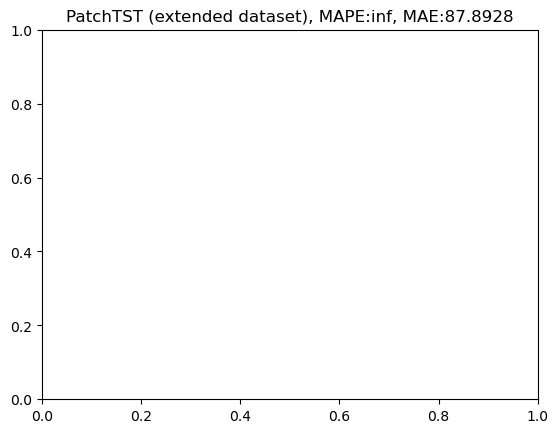

In [97]:
# model.eval()
# with torch.inference_mode():
#   x, y = next(iter(tst_dl))
#   x, y = x.cuda(), y.cuda()
#   p = model(x)

y = scaler2.inverse_transform(y.cpu())
p = scaler2.inverse_transform(p.cpu())

y = np.concatenate([y[:,0], y[-1,1:]])
p = np.concatenate([p[:,0], p[-1,1:]])

plt.title(f"PatchTST (extended dataset), MAPE:{mape(torch.Tensor(p),torch.Tensor(y)):.4f}, MAE:{mae(torch.Tensor(p),torch.Tensor(y)):.4f}")
plt.plot(range(tst_size), y, label="True")
plt.plot(range(tst_size), p, label="Prediction")
plt.legend()
plt.show()

In [ ]:
scaler2.inverse_transform(y)

array([[       0.        ,        0.        ,        0.        ,
        16277597.90670936]])